<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/autoencoder_v_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script concentrates on applying autoencoders in diatom design.

The final goal remains the same as script "main": to establish a pipeline of both forward and inverse problem.

Also refer script "data_visulaize" for pca analysis.

# Mount Drive

In [79]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

## Create Dataset

In [81]:
path_dataset = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_679.npz'

data = np.load(path_dataset)
# print(data['param'].shape)
# print(data['R'].shape)
# print(data['T'].shape)



param = data['param']
spectra_R = data['R'][...,1]
spectra_T = data['T'][...,1]
print(spectra_R[0])
print(spectra_T[0])

# select param, reduce spectra dim
idx_pick_param = [1,3,5,6,7,8,9]
param = param[...,idx_pick_param]
# inverse_param = 1./param
# param = np.concatenate((param,inverse_param), axis=1)
# spectra_R = spectra_R[...,::3]
# spectra_T = spectra_T[...,::3]
# spectra_T = spectra_T*10

# param_inverse = 1/param
# param = np.concatenate((param,param_inverse), axis=1)

# d = param[:,1]
# p = param[:,3]
# diff_dp = p-d
# # print(diff_dp.shape)
# param = np.concatenate((param,diff_dp[...,np.newaxis]), axis=1)


spectra_R = np.expand_dims(spectra_R, 1)
spectra_T = np.expand_dims(spectra_T, 1)
spectra_RT = np.concatenate((spectra_R,spectra_T), axis=1)
print(param.shape)
# print(spectra_R.shape)
# print(spectra_T.shape)
print(spectra_RT.shape)
# print(param[0])
# print(spectra_RT[0])

[0.94092533 0.94064921 0.94037978 ... 0.62366353 0.6234233  0.62318264]
[0.0164127  0.01644843 0.0164848  ... 0.00278186 0.0027883  0.00279488]
(679, 7)
(679, 2, 1001)


In [82]:
tensor_x = torch.Tensor(param) # transform to torch tensor
# tensor_y = torch.Tensor(spectra_RT)
tensor_y = torch.Tensor(spectra_R.squeeze())

print(tensor_x.shape)
print(tensor_y.shape)

dataset_ref_train = TensorDataset(tensor_x,tensor_y)

# dataset_ref_train, dataset_ref_test = random_split(dataset_ref, [200, 19], generator=torch.Generator().manual_seed(7))
print(len(dataset_ref_train))
# print(len(dataset_ref_test))

dataloader_ref_train = DataLoader(dataset_ref_train, batch_size=10, shuffle=True)
# dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_train))
# print(len(dataloader_ref_test))

torch.Size([679, 7])
torch.Size([679, 1001])
679
68


## Create Testset

In [83]:
path_dataset_test = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_test.npz'

data_test = np.load(path_dataset_test)

param_test = data_test['param']
spectra_R_test = data_test['R'][...,1]
spectra_T_test = data_test['T'][...,1]

# select param, reduce spectra dim
idx_pick_param = [1,3,5,6,7,8,9]
param_test = param_test[...,idx_pick_param]
# inverse_param_test = 1./param_test
# param_test = np.concatenate((param_test,inverse_param_test), axis=1)
# spectra_R_test = spectra_R_test[...,::3]
# spectra_T_test = spectra_T_test[...,::3]
# spectra_T_test = spectra_T_test*10

# d = param_test[:,1]
# p = param_test[:,3]
# diff_dp = p-d
# # print(diff_dp.shape)
# param_test = np.concatenate((param_test,diff_dp[...,np.newaxis]), axis=1)


spectra_R_test = np.expand_dims(spectra_R_test, 1)
spectra_T_test = np.expand_dims(spectra_T_test, 1)
spectra_RT_test = np.concatenate((spectra_R_test,spectra_T_test), axis=1)
print(param_test.shape)
# print(spectra_R_test.shape)
# print(spectra_T_test.shape)
print(spectra_RT_test.shape)

(40, 7)
(40, 2, 1001)


In [84]:
tensor_x_test = torch.Tensor(param_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(spectra_RT_test)
tensor_y_test = torch.Tensor(spectra_R_test.squeeze())

print(tensor_x_test.shape)
print(tensor_y_test.shape)

dataset_ref_test = TensorDataset(tensor_x_test,tensor_y_test)

dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_test))

torch.Size([40, 7])
torch.Size([40, 1001])
4


## Create Mega Dataset

In [85]:
tensor_x_mega = torch.cat((tensor_x, tensor_x_test), 0)
tensor_y_mega = torch.cat((tensor_y, tensor_y_test), 0)

dataset_ref_mega = TensorDataset(tensor_x_mega,tensor_y_mega)
dataloader_ref_mega = DataLoader(dataset_ref_mega, batch_size=10, shuffle=True)

print(len(dataset_ref_mega))

719


# Model

## Model Construct

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out


class NetAutoencoder(nn.Module):
    def __init__(self, dim_in, hidden_dim=10):
        super(NetAutoencoder, self).__init__()
        self.dim_in = dim_in
        self.hidden_dim = hidden_dim

        self.fc_encoder = nn.Sequential(
        nn.Linear(self.dim_in, 1500),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(1500, 500),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(500, 100),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(100, self.hidden_dim),
        # nn.ReLU(True),
        # nn.Sigmoid(),
        )

        self.fc_decoder = nn.Sequential(
        nn.Linear(self.hidden_dim, 100),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(100, 500),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(500, 1500),
        nn.ReLU(True),
        # nn.Sigmoid(),
        nn.Linear(1500, self.dim_in),
        # nn.ReLU(True),
        nn.Sigmoid(),
        )


    def forward(self, x):
        hidden_out = self.fc_encoder(x)
        out = self.fc_decoder(hidden_out)

        return out, hidden_out


## Train & Test Function

In [87]:
def train_model(train_dataloader, test_dataloader, optimizer, loss, net, device, NUM_EPOCH=5, scheduler=None, use_logger=False):
    net = net.to(device)
    net.train()
    spectra_weight = np.array([1,100])
    spectra_weight = torch.from_numpy(spectra_weight).to(device).float()

    if scheduler != None:
        print('*** WILL USE SCHEDULER ***')

    for i in range(NUM_EPOCH):
        running_loss = 0.0
        # running_acc = 0.0
        for idx, data in enumerate(train_dataloader):
            X, y = data
            # print(X.shape)
            # print(y.shape)

            X = X.to(device)
            y = y.to(device)

            # if idx==0:
            #     print(X.shape, y.shape)

            # y_pred = net(X)
            y_reconstruct, y_hidden = net(y)

            optimizer.zero_grad()
            # loss_train = loss(y_pred, y)
            loss_train = loss(y_reconstruct, y)  # used for autoencoder
            # loss_train = loss(y_pred, y, spectra_weight)

            loss_train.backward()
            optimizer.step()
            running_loss += loss_train.item()

            # if (idx+1)%5==0:
            #     print('EPOCH '+str(i+1)+'/'+str(NUM_EPOCH)+' || '+'STEP '+str(idx+1)+'/'+str(len(train_dataloader))+' || '+'LOSS: '+str(running_loss/(idx+1)))
            #     print('===================================================')
        print('----------------------------------------------------------------------')
        print('*** EPOCH '+str(i+1)+' || AVG LOSS '+str(running_loss/len(train_dataloader)))
        # print('----------------------------------------------------------------------')

        # test model for each epoch
        test_model(test_dataloader, loss, net, device, i, use_logger)

        # Tensorboard Logger
        if use_logger:
            logger.add_scalar(DATA_NAME_LOSS_TRAIN, running_loss/len(train_dataloader), (i+1))
            

In [88]:
def test_model(test_dataloader, loss, net, device, idx_epoch, use_logger_test=False):
    net = net.to(device)
    net.eval()
    spectra_weight = np.array([1,100])
    spectra_weight = torch.from_numpy(spectra_weight).to(device).float()

    running_loss = 0.0
    for idx, data in enumerate(test_dataloader):
        X, y = data

        X = X.to(device)
        y = y.to(device)

        # y_pred = net(X)
        y_reconstruct, y_hidden = net(y)

        # loss_train = loss(y_pred, y)
        loss_train = loss(y_reconstruct, y)  # used for autoencoder
        # loss_train = loss(y_pred, y, spectra_weight)
        running_loss += loss_train.item()

    # print('----------------------------------------------------------------------')
    print('### TEST LOSS ', str(running_loss/len(test_dataloader)))
    # print('### TEST LOSS ', str(running_loss/(idx+1)))
    # print('----------------------------------------------------------------------')

    # Tensorboard Logger
    if use_logger_test:
        logger.add_scalar(DATA_NAME_LOSS_TEST, running_loss/len(test_dataloader), (idx_epoch+1))

# Train & Test

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# learning_rate = 1e-3
learning_rate = 5e-4
# learning_rate = 1e-4

# torch.manual_seed(123)


net_dense = NetAutoencoder(1001,20)
net_dense = net_dense.to(device)

# optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
# optimizer = torch.optim.Adagrad(net_dense.parameters(), lr=learning_rate, lr_decay=0.9)
# optimizer = torch.optim.Adadelta(net_dense.parameters(), lr=learning_rate)
criteon = nn.MSELoss()
# criteon = SpectraMSELoss(use_target_weight=False)
scheduler = None


train_model(dataloader_ref_train, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=2000, scheduler=scheduler, use_logger=False)
# train_model(dataloader_ref_mega, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=2000, scheduler=scheduler, use_logger=False)

流式输出内容被截断，只能显示最后 5000 行内容。
*** EPOCH 334 || AVG LOSS 3.243141029141792e-05
### TEST LOSS  0.00014491572437691502
----------------------------------------------------------------------
*** EPOCH 335 || AVG LOSS 3.264023919601801e-05
### TEST LOSS  0.0001423509093001485
----------------------------------------------------------------------
*** EPOCH 336 || AVG LOSS 3.037062685293409e-05
### TEST LOSS  0.0001354216992695001
----------------------------------------------------------------------
*** EPOCH 337 || AVG LOSS 3.063068866407882e-05
### TEST LOSS  0.00013960378237243276
----------------------------------------------------------------------
*** EPOCH 338 || AVG LOSS 2.9195060265277897e-05
### TEST LOSS  0.00013553657299780753
----------------------------------------------------------------------
*** EPOCH 339 || AVG LOSS 2.9687592820985574e-05
### TEST LOSS  0.00014726517110830173
----------------------------------------------------------------------
*** EPOCH 340 || AVG LOSS 3.009

## Save Model

In [ ]:
# # save model
# # PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet7_forward_R_E2000.pt'
# PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densetransnet10_forward_RT_E2000.pt'
# # torch.save(net_dense.state_dict(), PATH_MODEL)
# torch.save(net_dense, PATH_MODEL)

# print('MODEL SAVED')

MODEL SAVED


# Load Model (Optional)

In [ ]:
# # PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet7_forward_R_E2000.pt'
# PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densetransnet10_forward_RT_E2000.pt'

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # net_dense = NetDense(11,1001)
# # net_dense.load_state_dict(torch.load(PATH_MODEL))
# net_dense = torch.load(PATH_MODEL)
# net_dense = net_dense.to(device)
# net_dense.eval()

# print('MODEL LOADED')
# print(device)

MODEL LOADED
cuda:0


## Visualize Loaded Model

torch.Size([679, 7])
torch.Size([679, 1001])
torch.Size([9, 7])
torch.Size([9, 1001])
(9, 1001)
(9, 1001)


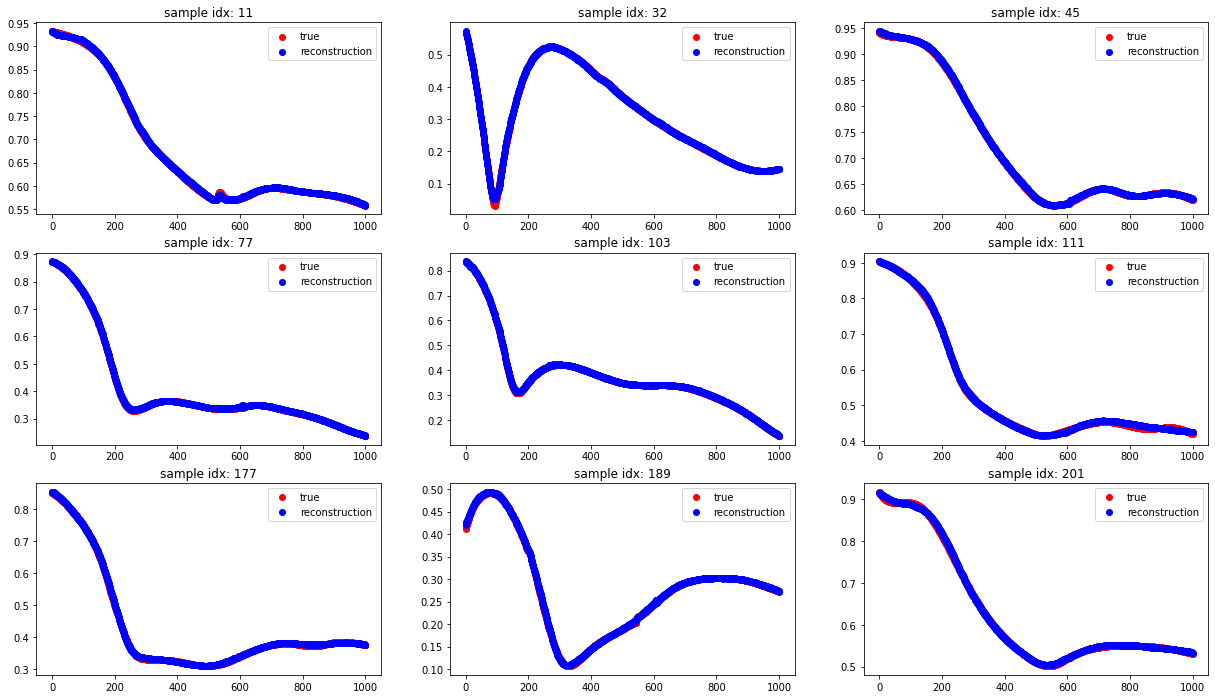

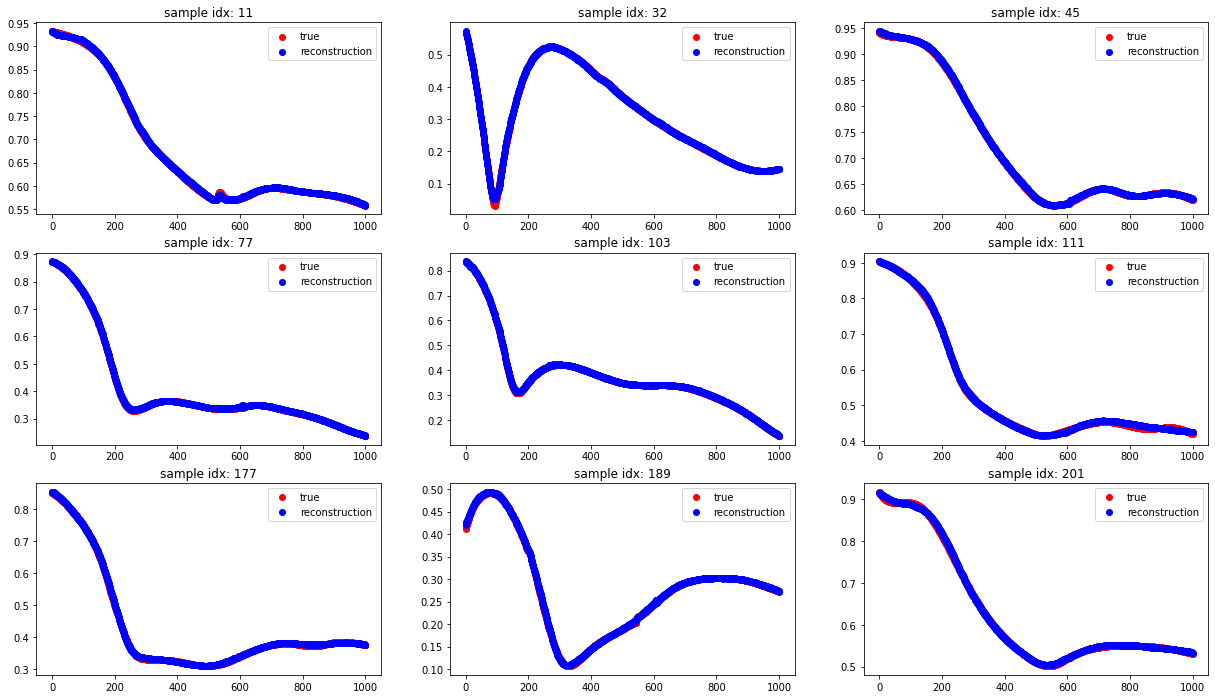

In [90]:
idx_test = [11,32,45,77,103,111,177,189,201]
# idx_test = [241,270,372,461,484,496,502,510,562]  # special spectra
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:]
y_test = tensor_y[idx_test,:]
print(X_test.shape)
print(y_test.shape)

y_test = y_test.to(device)
y_test_reconstruct, y_hidden = net_dense(y_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_reconstruct_np = y_test_reconstruct.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_reconstruct_np.shape)


plt.figure(1, figsize=(21,12))
plt.title('R')
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    # plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
    # plt.scatter(np.arange(y_test_reconstruct_np.shape[2]), y_test_reconstruct_np[idx_fig,0,:], c='b')
    plt.scatter(np.arange(y_test_np.shape[1]), y_test_np[idx_fig,:], c='r')
    plt.scatter(np.arange(y_test_reconstruct_np.shape[1]), y_test_reconstruct_np[idx_fig,:], c='b')
    plt.legend(('true', 'reconstruction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))


plt.figure(2, figsize=(21,12))
plt.title('T')
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    # plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
    # plt.scatter(np.arange(y_test_reconstruct_np.shape[2]), y_test_reconstruct_np[idx_fig,1,:], c='b')
    plt.scatter(np.arange(y_test_np.shape[1]), y_test_np[idx_fig,:], c='r')
    plt.scatter(np.arange(y_test_reconstruct_np.shape[1]), y_test_reconstruct_np[idx_fig,:], c='b')
    plt.legend(('true', 'reconstruction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))

In [78]:
print(y_hidden)  # hidden dim = 20

tensor([[-2.6126e+00, -3.6843e-01, -1.5712e+00, -8.2038e-01,  1.4896e+00,
         -1.8104e+00,  1.4079e-01, -1.4281e+00,  1.7808e+00, -2.1537e-01,
          1.5254e-01, -9.7609e-01,  2.9266e+00,  7.4215e-01, -5.4008e-01,
         -1.3051e-01,  8.2413e-01,  3.3497e-01,  5.8029e-01, -1.0109e+00],
        [-2.6579e+00, -3.1706e-01, -1.6091e+00, -8.8190e-01,  1.5235e+00,
         -1.8586e+00,  1.3054e-01, -1.5119e+00,  1.8022e+00, -1.8592e-01,
          1.7996e-01, -9.2779e-01,  2.9006e+00,  6.9778e-01, -5.0678e-01,
         -1.6696e-01,  8.6453e-01,  3.0795e-01,  5.9493e-01, -9.7164e-01],
        [-2.9076e+00, -1.9229e-01, -1.5964e+00, -1.2198e+00,  2.9008e+00,
         -1.6345e+00,  5.2480e-01, -1.0183e+00,  1.5779e+00, -3.4149e-01,
         -3.5710e-01, -6.1085e-01,  3.1346e+00,  9.1701e-01, -1.5963e-01,
         -2.1779e-01,  8.4079e-01,  1.1604e+00, -4.5455e-01, -1.3792e-01],
        [-3.3855e+00, -2.4082e-01, -1.7247e+00, -1.0552e+00,  2.5789e+00,
         -1.9765e+00,  5.8586e-01, 

In [65]:
print(y_hidden)  # hidden dim = 10

tensor([[ 2.1629, -1.0640,  0.5119,  1.0854,  2.6521,  0.7744,  0.4946,  1.9310,
         -1.4549,  2.9837],
        [ 2.2872, -1.0678,  0.4585,  1.0653,  2.5769,  0.8167,  0.5351,  1.9522,
         -1.5159,  2.9891],
        [ 2.8888, -0.1033,  0.7005,  0.1657,  1.5997,  0.0127,  1.2666,  1.2809,
         -0.5146,  3.4656],
        [ 2.8977, -0.6603,  0.9260,  0.9213,  2.8682,  0.1628,  0.7393,  1.9571,
         -1.4259,  3.9783],
        [ 2.7161, -0.4022,  1.4329,  0.9854,  2.9091, -0.3881,  0.5784,  2.2741,
         -1.5046,  4.0149],
        [ 2.8052, -0.4929,  1.2771,  0.9783,  2.8782, -0.1774,  0.6521,  2.2309,
         -1.4995,  4.0009],
        [ 2.5767, -0.3961,  1.5444,  1.0389,  3.0406, -0.5130,  0.4589,  2.3003,
         -1.5363,  4.0061],
        [ 1.9483, -0.2425,  1.6603,  0.7626,  2.8005, -0.6012,  0.5002,  1.8681,
         -0.4492,  3.6397],
        [ 0.7529, -0.2267,  1.2399,  0.0387,  1.4091,  0.1339,  0.8744,  0.9868,
          1.5705,  1.8650]], device='cuda:0', g